# 10.4.1 VaR
 - VaR(Value at Risk) : 주어진 신뢰수준 하에서 특정 기간 내에 발생할 수 최대 손실 금액

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as scs

#### 1. 정적 시뮬레이션 VaR

In [2]:
S0 = 100
r = 0.05
sig = 0.25
T = 30 / 365.
i = 10000
ST = S0 * np.exp((r - 0.5 * sig ** 2) * T + sig * np.sqrt(T) * npr.standard_normal(i))

In [3]:
R_gbm = np.sort(ST - S0) # 손익을 정렬(오름차순)

In [4]:
R_gbm

array([-24.4271387 , -21.69870371, -21.53167975, ...,  26.48339176,
        29.60562648,  30.46750355])

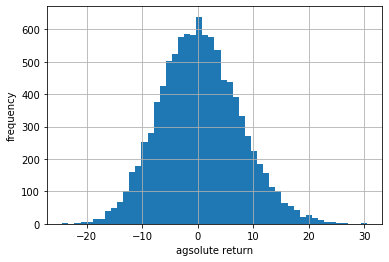

In [5]:
plt.hist(R_gbm, bins = 50)
plt.xlabel('agsolute return')
plt.ylabel('frequency')
plt.grid(True)

In [6]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0] # %기준
var = scs.scoreatpercentile(R_gbm, percs)
print("%16s %16s" % ('Confidence Level', 'Value at Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print("%16.2f %16.2f" % (100 - pair[0], -pair[1]))

Confidence Level    Value at Risk
---------------------------------
           99.99            21.70
           99.90            19.51
           99.00            15.24
           97.50            12.92
           95.00            11.00
           90.00             8.63


#### 2. 점프 확산 모형을 이용한 동적 시뮬레이션 VaR

In [7]:
lamb = 0.75
mu = -0.6
delta = 0.25
M = 50

In [8]:
dt = 30. / 365 / M
rj = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
S = np.zeros((M + 1, i))
S[0] = S0

sn1 = npr.standard_normal((M + 1, i))
sn2 = npr.standard_normal((M + 1, i))
poi = npr.poisson(lamb * dt, (M + 1, i))

for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sig ** 2) * dt + sig * np.sqrt(dt) * sn1[t])
                      + (np.exp(mu + delta * sn2[t]) - 1) * poi[t])
    S[t] = np.maximum(S[t], 0)

In [9]:
R_jd = np.sort(S[-1] - S0)

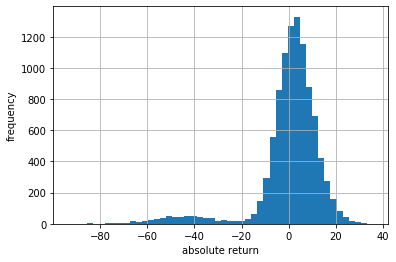

In [10]:
plt.hist(R_jd, bins = 50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.grid(True)

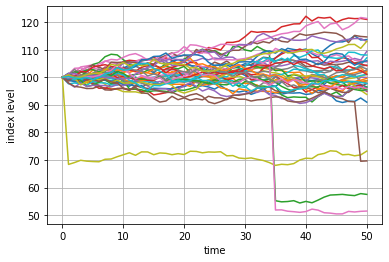

In [11]:
plt.plot(S[:, :40], lw = 1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

점프 요인이 음수 -> 손익이 Left fat tail을 가진다

In [12]:
var = scs.scoreatpercentile(R_jd, percs)
print("%16s %16s" % ('Confidence Level', 'Value at Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print("%16.2f %16.2f" % (100 - pair[0], -pair[1]))

Confidence Level    Value at Risk
---------------------------------
           99.99            85.36
           99.90            72.17
           99.00            56.27
           97.50            47.00
           95.00            32.19
           90.00             9.32


90% 신뢰도를 가진 30일 VaR 값은 1,2의 경우가 큰차이 없다 But, 99% 신뢰도의 VaR는 2의 결과가 1의 결과보다 3배 이상 차이난다.

-> 종종 발생하는 Tail Risk 반영 못함

(-97.41870154453814, 0.0)

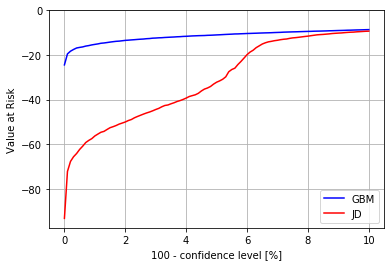

In [13]:
percs = list(np.arange(0.0, 10.1, 0.1))
gbm_var = scs.scoreatpercentile(R_gbm, percs)
jd_var = scs.scoreatpercentile(R_jd, percs)

plt.plot(percs, gbm_var, 'b', lw = 1.5, label = 'GBM')
plt.plot(percs, jd_var, 'r', lw = 1.5, label = 'JD')
plt.legend(loc = 0)
plt.xlabel('100 - confidence level [%]')
plt.ylabel('Value at Risk')
plt.grid(True)
plt.ylim(ymax = 0.0)

# 10.4.2 CVA
 - CVA(Credit Value Adjustment) : 거래 상대방이 이행의무를 다하지 않을 가능성을 고려한 위험 측도
 - Ex) 파산 : 부도확률 & 손실 수준의 두 가지 가정 필요

In [14]:
S0 = 100.
r = 0.05
sig = 0.2
T = 1.
i = 100000
ST = S0 * np.exp((r - 0.5 * sig ** 2) * T + sig * np.sqrt(T) * npr.standard_normal(i))

In [15]:
L = 0.5 # 손실 수준
p = 0.01 # 1년 부도 확률

In [16]:
# 부도 시나리오 : 포아송 분포를 사용하여 생성 & 1번만 발생
D = npr.poisson(p * T, i)
D = np.where(D > 1, 1, D)

In [17]:
print(D)

[0 0 0 ... 0 0 0]


In [18]:
# 부도 발생 X
print(np.exp(-r * T) / i * np.sum(ST))

# 부도 발생 O
CVaR = np.exp(-r * T) / i * np.sum(L * D * ST)
print(CVaR)

# 신용 위험 조정 후 현재 가치
S0_CVA = np.exp(-r * T) / i * np.sum((1 - L * D) * ST)
print(S0_CVA)

99.96495393506022
0.5051267576079674
99.45982717745227


In [19]:
S0_adj = S0 - CVaR
S0_adj

99.49487324239203

S0_CVA와 S0_adj가 거의 일치해야한다.

In [20]:
np.count_nonzero(L * D * ST)

1015

100000개의 시뮬레이션중 손실이 발생하는 경우는 약 1000개 -> 위에서 가정한 부도 확률(p) 1%와 거의 일치

(0.0, 200)

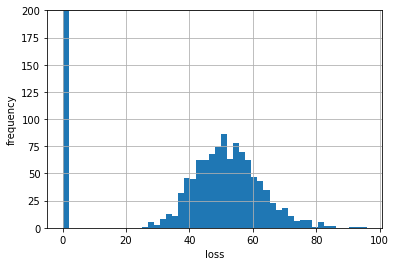

In [21]:
plt.hist(L * D * ST, bins = 50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax = 200)

In [22]:
K = 100.
hT = np.maximum(ST - K, 0)
C0 = np.exp(-r * T) / i * np.sum(hT)
C0

10.425870981705556

In [23]:
CVaR = np.exp(-r * T) / i * np.sum(L * D * hT)
CVaR

0.05098854657593399

In [24]:
# 조정한 옵션 가치
C0_CVA = np.exp(-r * T) / i * np.sum((1- L * D) * hT)
C0_CVA

10.374882435129622

In [25]:
print(np.count_nonzero(L * D * hT))
print(np.count_nonzero(D))
print(np.count_nonzero(hT))

578
1015
56005


자산의 경우 부도로 인한 손실이 약 1000회 이지만 옵션의 경우는 약 500회 -> 옵션의 만기 Pay-Off가 0이 될 확률이 높기 때문

(0.0, 350)

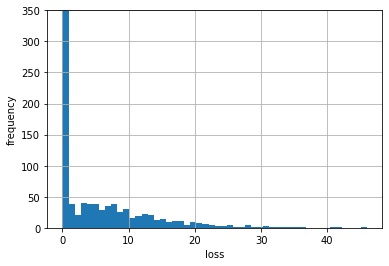

In [26]:
plt.hist(L * D * hT, bins = 50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax = 350)